# Re-reconsidering the negative income tax

Revisits [Wiederspan, Rhodes and Shaefer (2015)](https://drive.google.com/file/d/0B5yUTVqCinNRdWo3YVlhZFZIRlU/view?usp=sharing): *Expanding the Discourse on Antipoverty Policy: Reconsidering a Negative Income Tax*.

This paper with a negative income tax these programs, using :
* EITC
* SSI
* SNAP
* TANF
* School meal programs
* Housing subsidies

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'0.19.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 75
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [6]:
# Show one decimal in tables.
pd.set_option('precision', 2)

### Utilities

From https://stackoverflow.com/a/48999797/1840471.

In [7]:
def gini(x, w=None):
    # Requires float numpy arrays (not pandas Series or lists) to work.
    x = np.array(x).astype('float')
    if w is not None:
        w = np.array(w).astype('float')
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        cumw = np.cumsum(sorted_w)
        cumxw = np.cumsum(sorted_x * sorted_w)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumxw = np.cumsum(sorted_x)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumxw) / cumxw[-1]) / n

2018 HHS Poverty Guidelines (Federal Poverty Level) for 48 Contiguous States and District of Columbia (Alaska and Hawaii have higher guidelines, but the data does not have state code): https://aspe.hhs.gov/poverty-guidelines

In [8]:
def fpl(XTOT):
    return 7820 + 4320 * XTOT

In [9]:
def weight(df, col):
    return df[col] * df.s006

def weighted_sum(df, col):
    return (weight(df, col)).sum()

def weighted_mean(df, col):
    return weighted_sum(df, col) / df.s006.sum()

## Data

In [10]:
recs = tc.Records.cps_constructor()
calc = tc.Calculator(records=recs, policy=tc.Policy(), verbose=False)
calc.advance_to_year(2018)
calc.calc_all()

TODO: Try a reform with EITC repeal in case it affects other credits.

Ordered biggest to smallest for charting.

In [11]:
BENS = ['snap_ben', 'eitc', 'ssi_ben', 'housing_ben', 'tanf_ben']
OTHER_COLS = ['XTOT', 'expanded_income', 'aftertax_income']

In [12]:
# 'ffpos', 'FLPDYR'
df_tu = calc.dataframe(['s006', 'h_seq', 'RECID'] + BENS + OTHER_COLS)
df_tu['filers'] = 1

In [13]:
for i in BENS + OTHER_COLS + ['filers']:
    df_tu[i + '_b'] = df_tu[i] * df_tu.s006 / 1e9

### Create household-level dataset

In [14]:
df = df_tu.groupby(['h_seq']).sum().reset_index()

In [15]:
df['hh_s006'] = df.s006 / df.filers

In [16]:
df.hh_s006.sum() / 1e6

53.663831758721415

In [17]:
weighted_sum(df_tu, 'aftertax_income') / 1e9

11562.56861919646

In [18]:
df_tu.shape

(456465, 21)

In [19]:
df_tu.RECID.unique().size

456465

In [20]:
df_tu.XTOT_b.sum() * 1e3

334.6129186299999

In [21]:
df_tu.filers_b.sum() * 1e3

169.89483966

In [22]:
df.filers_b.sum() * 1e3

169.89483966000003

In [23]:
(df_tu.XTOT * df_tu.s006).sum() / 1e6

334.61291863000014

In [24]:
(df.XTOT * df.s006).sum() / 1e6

2057.8212440899997

In [245]:
df.groupby('XTOT').s006.sum().cumsum() / df.s006.sum()

XTOT
1.0      0.08
2.0      0.15
3.0      0.24
4.0      0.35
5.0      0.46
6.0      0.56
7.0      0.65
8.0      0.72
9.0      0.77
10.0     0.81
11.0     0.83
12.0     0.85
13.0     0.86
14.0     0.86
15.0     0.87
16.0     0.87
17.0     0.88
18.0     0.88
19.0     0.89
20.0     0.89
21.0     0.89
22.0     0.89
23.0     0.90
24.0     0.90
25.0     0.90
26.0     0.90
27.0     0.90
28.0     0.90
29.0     0.90
30.0     0.90
         ... 
121.0    1.00
122.0    1.00
123.0    1.00
124.0    1.00
125.0    1.00
126.0    1.00
128.0    1.00
129.0    1.00
130.0    1.00
135.0    1.00
136.0    1.00
137.0    1.00
138.0    1.00
139.0    1.00
140.0    1.00
141.0    1.00
142.0    1.00
143.0    1.00
144.0    1.00
146.0    1.00
150.0    1.00
151.0    1.00
153.0    1.00
154.0    1.00
167.0    1.00
169.0    1.00
181.0    1.00
182.0    1.00
195.0    1.00
210.0    1.00
Name: s006, Length: 141, dtype: float64

### Add calculated fields

\$B of values, sums, and percentiles.

In [138]:
df['bens'] = df[BENS].sum(axis=1)
df['afti'] = df.aftertax_income
df['expi'] = df.expanded_income
# After-tax income before modeled benefits.
df['aftip'] = df.afti - df.bens
df['expi_pp'] = df.expi / df.XTOT
df['aftip_pp'] = df.aftip / df.XTOT
COLS_TO_SUM = BENS + ['bens', 'afti', 'aftip', 'expi', 'XTOT']

In [54]:
for i in COLS_TO_SUM:
    df[i + '_b'] = weight(df, i) / 1e9
    print(i, round(df[i + '_b'].sum(), 1))

('eitc', 59.6)
('ssi_ben', 57.0)
('housing_ben', 36.5)
('snap_ben', 78.9)
('tanf_ben', 7.8)
('bens', 239.8)
('afti', 11596.6)
('aftip', 11356.8)
('expi', 13918.2)
('XTOT', 0.3)


#### Percentiles

In [150]:
def add_weighted_quantiles(df, col):
    df.sort_values(by=col, inplace=True)
    col_pctile = col + '_percentile_exact'
    df[col_pctile] = 100 * df.s006.cumsum() / df.s006.sum()
    # "Null out" negatives using -0, since integer arrays can't be NaN.
    # TODO: Should these be null floats?
    df[col_pctile] = np.where(df[col] >= 0, df[col_pctile], 0)
    # Reduce top record, otherwise it's incorrectly rounded up.
    df[col_pctile] = np.where(df[col_pctile] >= 99.99999, 99.99999, 
                              df[col_pctile])
    df[col + '_percentile'] = np.ceil(df[col_pctile]).astype(int)
    # Center 2percentiles as percentiles.
    df[col + '_2percentile'] = 2 * np.ceil(df[col_pctile] / 2).astype(int) - 1
    # Center ventiles as percentiles.
    df[col + '_ventile'] = 5 * np.ceil(df[col_pctile] / 5).astype(int) - 2.5
    df[col + '_decile'] = np.ceil(df[col_pctile] / 10).astype(int)
    df[col + '_quintile'] = np.ceil(df[col_pctile] / 20).astype(int)
    df[col + '_quartile'] = np.ceil(df[col_pctile] / 25).astype(int)
    return df

In [151]:
df = add_weighted_quantiles(df, 'expi')
df = add_weighted_quantiles(df, 'aftip')
df = add_weighted_quantiles(df, 'expi_pp')
df = add_weighted_quantiles(df, 'aftip_pp')

### Add NIT

Six combinations of these two variables:

* Minimum threshold as a share of poverty (FPL): 75%, 100%, 133%
* Marginal tax rate (i.e., phase-out): 50%, 33%

![fd](https://imgur.com/PsW6fUU.png)

In [58]:
df['fpl'] = fpl(df.XTOT)

In [74]:
def phase_out(c, ps, inc):
    return np.where(inc <= 0, c,
                    np.where(inc >= (c / ps), 0,
                             c - (inc * ps)))

In [126]:
for c in [75, 100, 133]:
    for ps in [67, 50, 33]:
        for inc in ['expi', 'aftip']:
            col = 'nit_' + str(c) + '_' + str(ps) + '_' + inc
            df[col] = phase_out(c * df.fpl / 100., ps / 100., df[inc])
            df[col + '_b'] = weight(df, col) / 1e9

In [137]:
df[['nit_75_33_expi_b', 'nit_100_33_expi_b', 'nit_133_33_expi_b', 
    'nit_75_50_expi_b', 'nit_100_50_expi_b', 'nit_133_50_expi_b',
    'nit_75_67_expi_b', 'nit_100_67_expi_b', 'nit_133_67_expi_b',
    'nit_75_33_aftip_b', 'nit_100_33_aftip_b', 'nit_133_33_aftip_b', 
    'nit_75_50_aftip_b', 'nit_100_50_aftip_b', 'nit_133_50_aftip_b',
    'nit_75_67_aftip_b', 'nit_100_67_aftip_b', 'nit_133_67_aftip_b']].sum()

nit_75_33_expi_b       280.81
nit_100_33_expi_b      543.18
nit_133_33_expi_b     1004.55
nit_75_50_expi_b       163.28
nit_100_50_expi_b      315.49
nit_133_50_expi_b      612.76
nit_75_67_expi_b       117.50
nit_100_67_expi_b      216.39
nit_133_67_expi_b      415.44
nit_75_33_aftip_b      346.61
nit_100_33_aftip_b     656.93
nit_133_33_aftip_b    1188.33
nit_75_50_aftip_b      204.27
nit_100_50_aftip_b     392.01
nit_133_50_aftip_b     748.28
nit_75_67_aftip_b      146.37
nit_100_67_aftip_b     270.72
nit_133_67_aftip_b     516.34
dtype: float64

### Create summary tables

In [171]:
def add_ratios(df):
    for i in BENS + ['bens', 'nit_100_50_aftip']:
        df[i + '_pp'] = df[i + '_b'] / df.XTOT_b
    
#     df['repeal_afti_chg'] = df.afti_repeal_b - df.afti_keep_b
#     df['repeal_afti_pctchg'] = 100 * df.repeal_afti_chg / df.afti_keep_b

In [166]:
def quantile_summary(df, groupby):
    qs = df.groupby(groupby).sum()
    add_ratios(qs)
    # Exclude 0, the negative group.
    return qs.loc[1:]

In [ ]:
quantile_summary(df, 'aftip_pp_decile')[[s + '_pp' for s in BENS]].plot.area()
plt.show()

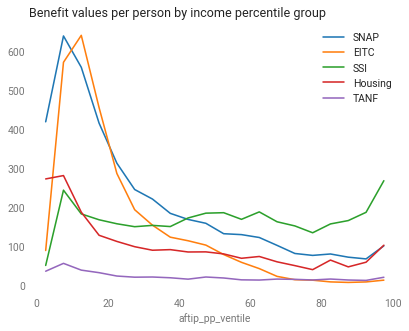

In [169]:
quantile_summary(df, 'aftip_pp_ventile')[[s + '_pp' for s in BENS]].plot()
sns.despine(left=True, bottom=True)
plt.legend(['SNAP', 'EITC', 'SSI', 'Housing', 'TANF'])
plt.title('Benefit values per person by income percentile group', loc='left')
plt.show()

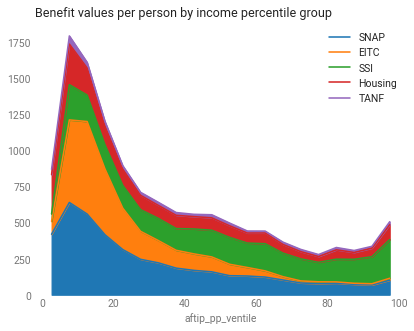

In [170]:
quantile_summary(df, 'aftip_pp_ventile')[[
    s + '_pp' for s in BENS]].plot.area()
sns.despine(left=True, bottom=True)
plt.legend(['SNAP', 'EITC', 'SSI', 'Housing', 'TANF'])
plt.title('Benefit values per person by income percentile group', loc='left')
plt.show()

In [180]:
recs.s006.sum() #/ 117.7e6

162968130.0

In [176]:
df.s006.sum()  # 126M households?

169894839.66

In [177]:
df.s006.sum() / 126e6 # 126M households?

1.3483717433333333

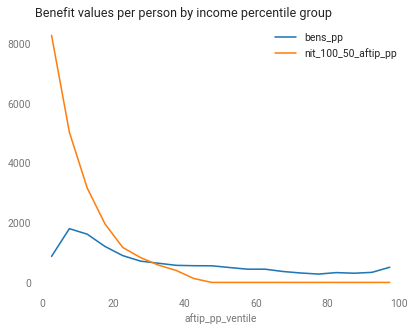

In [174]:
quantile_summary(df, 'aftip_pp_ventile')[['bens_pp', 
                                          'nit_100_50_aftip_pp']].plot()
sns.despine(left=True, bottom=True)
# plt.legend(['SNAP', 'EITC', 'SSI', 'Housing', 'TANF'])
plt.title('Benefit values per person by income percentile group', loc='left')
plt.show()

In [142]:
df[df.snap_ben > 0].expanded_income.max()

5137145.4273059294

## Exploratory

Current distribution of benefits programs as listed in Wiederspan et al:

![fd](https://i.imgur.com/LrYROJp.png)

These are:
* `eitc`
* `ssi_ben`
* `housing_ben`
* `snap_ben`
* `tanf_ben` (too low, should be \$29B in 2014: https://github.com/open-source-economics/C-TAM/issues/65)

School food programs are not explicitly modeled.

In [44]:
df.columns

Index([u's006', u'XTOT', u'expanded_income', u'aftertax_income', u'eitc',
       u'ssi_ben', u'housing_ben', u'snap_ben', u'tanf_ben', u'bens', u'afti',
       u'expi', u'afti_preben', u'eitc_b', u'ssi_ben_b', u'housing_ben_b',
       u'snap_ben_b', u'tanf_ben_b', u'bens_b', u'afti_b', u'afti_preben_b',
       u'expi_b', u'expi_percentile_exact', u'expi_percentile',
       u'expi_2percentile', u'expi_ventile', u'expi_decile', u'expi_quintile',
       u'expi_quartile', u'afti_preben_percentile_exact',
       u'afti_preben_percentile', u'afti_preben_2percentile',
       u'afti_preben_ventile', u'afti_preben_decile', u'afti_preben_quintile',
       u'afti_preben_quartile'],
      dtype='object')

In [45]:
df[BENS + '_b']

TypeError: can only concatenate list (not "str") to list